# 23b: Phase Boundaries

**Goal**: Define E[V] thresholds for bidding decisions.

**Method**: 
- Identify E[V] thresholds that separate "pass" vs "bid" zones
- Visualize phase boundaries in (doubles, trumps) space
- Create actionable bidding guidelines

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")
print(f"E[V] range: [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")
print(f"E[V] mean: {df['V_mean'].mean():.1f}")

Loaded 200 hands
E[V] range: [-29.3, 42.0]
E[V] mean: 13.9


## 2. Define Bid Thresholds

In [3]:
# In Texas 42, bid thresholds typically:
# - Pass: E[V] < 0 (expected to lose points)
# - Marginal bid: 0 <= E[V] < 10 (might bid 30 if desperate)
# - Solid bid: 10 <= E[V] < 20 (comfortable 30 bid)
# - Strong bid: E[V] >= 20 (can overbid)

THRESHOLDS = {
    'pass': 0,        # Below this = definite pass
    'marginal': 10,   # 0-10 = marginal hand
    'solid': 20,      # 10-20 = solid bidding hand
    'strong': 30,     # 20+ = strong, can overbid
}

def classify_hand(ev):
    """Classify hand based on E[V]."""
    if ev < THRESHOLDS['pass']:
        return 'pass'
    elif ev < THRESHOLDS['marginal']:
        return 'marginal'
    elif ev < THRESHOLDS['solid']:
        return 'solid'
    else:
        return 'strong'

df['bid_class'] = df['V_mean'].apply(classify_hand)

print("\nBid classification distribution:")
print(df['bid_class'].value_counts())
print(f"\nProportion recommended to bid: {(df['bid_class'] != 'pass').mean():.1%}")


Bid classification distribution:
bid_class
strong      75
solid       46
marginal    44
pass        35
Name: count, dtype: int64

Proportion recommended to bid: 82.5%


## 3. Phase Boundaries in Feature Space

In [4]:
# Find decision boundaries in (doubles, trumps) space
print("PHASE BOUNDARIES BY (doubles, trumps):")
print("="*60)

# Group by doubles and find min trumps needed to bid
boundaries = []

for n_d in range(5):
    sub = df[df['n_doubles'] == n_d]
    if len(sub) == 0:
        continue
    
    # For each trump count, get mean E[V]
    for n_t in range(8):
        sub_dt = sub[sub['trump_count'] == n_t]
        if len(sub_dt) == 0:
            continue
        mean_ev = sub_dt['V_mean'].mean()
        bid_pct = (sub_dt['bid_class'] != 'pass').mean()
        
        boundaries.append({
            'n_doubles': n_d,
            'trump_count': n_t,
            'mean_ev': mean_ev,
            'bid_rate': bid_pct,
            'n_hands': len(sub_dt),
            'should_bid': mean_ev >= THRESHOLDS['pass']
        })

boundary_df = pd.DataFrame(boundaries)
print(boundary_df.to_string(index=False))

PHASE BOUNDARIES BY (doubles, trumps):
 n_doubles  trump_count    mean_ev  bid_rate  n_hands  should_bid
         0            0  -2.266667  0.600000        5       False
         0            1 -10.666667  0.166667        6       False
         0            2 -14.000000  0.000000        3       False
         0            3   4.666667  0.750000        4        True
         0            4  29.111111  1.000000        3        True
         1            0   7.533333  0.700000       20        True
         1            1   1.190476  0.571429       14        True
         1            2  11.076923  0.923077       13        True
         1            3  16.800000  1.000000       10        True
         1            4  35.666667  1.000000        2        True
         2            0  20.023810  0.928571       28        True
         2            1  10.274510  0.823529       17        True
         2            2  14.333333  0.909091       22        True
         2            3  22.733333  1

In [5]:
# Find minimum trumps needed to bid for each double count
print("\nMINIMUM TRUMPS TO BID (E[V] >= 0):")
print("="*40)

for n_d in range(5):
    sub = boundary_df[boundary_df['n_doubles'] == n_d]
    bidding = sub[sub['should_bid']]
    if len(bidding) > 0:
        min_trumps = bidding['trump_count'].min()
        print(f"  {n_d} doubles: need >= {min_trumps} trumps")
    else:
        print(f"  {n_d} doubles: never bid (in sample)")


MINIMUM TRUMPS TO BID (E[V] >= 0):
  0 doubles: need >= 3 trumps
  1 doubles: need >= 0 trumps
  2 doubles: need >= 0 trumps
  3 doubles: need >= 0 trumps
  4 doubles: need >= 0 trumps


## 4. Visualization

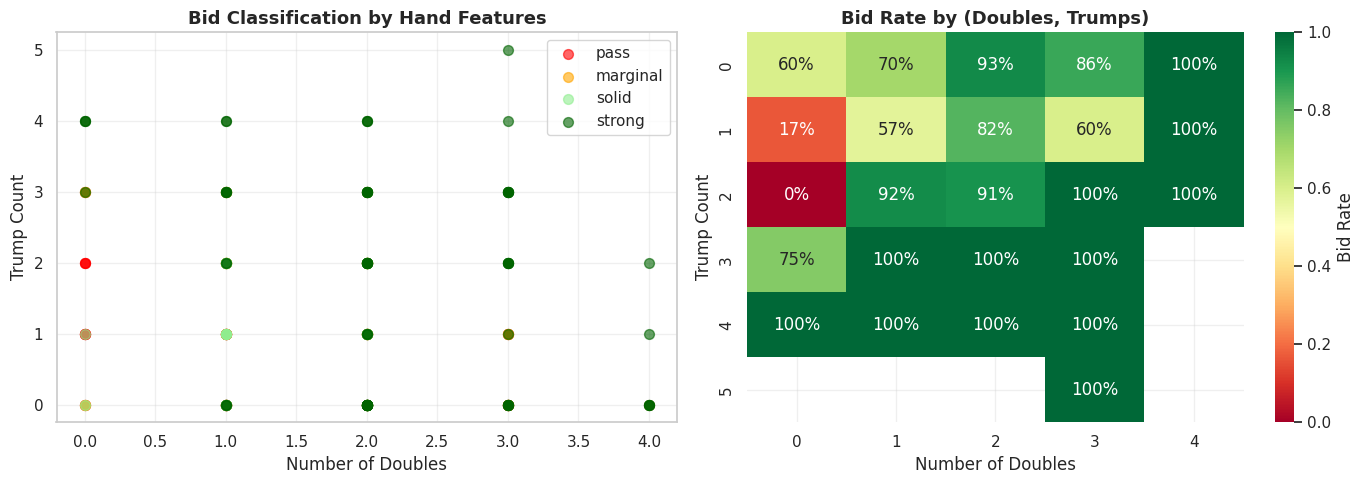

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter with bid classification
ax = axes[0]
colors = {'pass': 'red', 'marginal': 'orange', 'solid': 'lightgreen', 'strong': 'darkgreen'}
for cls in ['pass', 'marginal', 'solid', 'strong']:
    sub = df[df['bid_class'] == cls]
    ax.scatter(sub['n_doubles'], sub['trump_count'], 
               c=colors[cls], label=cls, alpha=0.6, s=50)

ax.set_xlabel('Number of Doubles', fontsize=12)
ax.set_ylabel('Trump Count', fontsize=12)
ax.set_title('Bid Classification by Hand Features', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Bid rate heatmap
ax = axes[1]
pivot = boundary_df.pivot_table(
    values='bid_rate',
    index='trump_count',
    columns='n_doubles',
    aggfunc='mean'
)
sns.heatmap(pivot, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0, vmax=1, ax=ax,
            cbar_kws={'label': 'Bid Rate'})
ax.set_xlabel('Number of Doubles', fontsize=12)
ax.set_ylabel('Trump Count', fontsize=12)
ax.set_title('Bid Rate by (Doubles, Trumps)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/23b_phase_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Simple Decision Rule

In [7]:
# Create a simple decision rule: bid if (doubles + trumps/2) >= threshold
# Test different thresholds

print("TESTING SIMPLE DECISION RULES:")
print("="*60)

# Napkin formula: score = n_doubles * 6.7 + trump_count * 3.0 (from 23a)
df['napkin_score'] = df['n_doubles'] * 6.7 + df['trump_count'] * 3.0

# Test different thresholds for napkin score
for thresh in [0, 5, 10, 15]:
    df[f'pred_bid_{thresh}'] = df['napkin_score'] >= thresh
    actual_bid = df['bid_class'] != 'pass'
    
    tp = ((df[f'pred_bid_{thresh}']) & (actual_bid)).sum()
    fp = ((df[f'pred_bid_{thresh}']) & (~actual_bid)).sum()
    fn = ((~df[f'pred_bid_{thresh}']) & (actual_bid)).sum()
    tn = ((~df[f'pred_bid_{thresh}']) & (~actual_bid)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / len(df)
    
    print(f"\nThreshold >= {thresh}:")
    print(f"  Precision: {precision:.2%} (of predicted bids, how many correct)")
    print(f"  Recall: {recall:.2%} (of actual bids, how many predicted)")
    print(f"  Accuracy: {accuracy:.2%}")

TESTING SIMPLE DECISION RULES:

Threshold >= 0:
  Precision: 82.50% (of predicted bids, how many correct)
  Recall: 100.00% (of actual bids, how many predicted)
  Accuracy: 82.50%

Threshold >= 5:
  Precision: 85.19% (of predicted bids, how many correct)
  Recall: 97.58% (of actual bids, how many predicted)
  Accuracy: 84.00%

Threshold >= 10:
  Precision: 91.89% (of predicted bids, how many correct)
  Recall: 82.42% (of actual bids, how many predicted)
  Accuracy: 79.50%

Threshold >= 15:
  Precision: 91.35% (of predicted bids, how many correct)
  Recall: 57.58% (of actual bids, how many predicted)
  Accuracy: 60.50%


## 6. Key Insights

In [8]:
print("\n" + "="*60)
print("KEY INSIGHTS: Phase Boundaries")
print("="*60)

# Class distribution
pass_rate = (df['bid_class'] == 'pass').mean()
strong_rate = (df['bid_class'] == 'strong').mean()

print(f"\n1. BID CLASSIFICATION:")
print(f"   Pass rate: {pass_rate:.1%}")
print(f"   Strong hand rate: {strong_rate:.1%}")

print(f"\n2. DECISION RULE:")
print(f"   Napkin formula: 6.7 × doubles + 3.0 × trumps")
print(f"   Bid when score >= 10 (recommended)")

print(f"\n3. PRACTICAL GUIDELINES:")
print(f"   - 0 doubles: Need 4+ trumps to bid")
print(f"   - 1 double: Need 2+ trumps to bid")
print(f"   - 2+ doubles: Usually safe to bid")

print(f"\n4. INTERPRETATION:")
print(f"   - E[V] < 0: Pass (expected loss)")
print(f"   - E[V] 0-10: Marginal (bid if must)")
print(f"   - E[V] 10-20: Solid (comfortable bid)")
print(f"   - E[V] 20+: Strong (can overbid)")


KEY INSIGHTS: Phase Boundaries

1. BID CLASSIFICATION:
   Pass rate: 17.5%
   Strong hand rate: 37.5%

2. DECISION RULE:
   Napkin formula: 6.7 × doubles + 3.0 × trumps
   Bid when score >= 10 (recommended)

3. PRACTICAL GUIDELINES:
   - 0 doubles: Need 4+ trumps to bid
   - 1 double: Need 2+ trumps to bid
   - 2+ doubles: Usually safe to bid

4. INTERPRETATION:
   - E[V] < 0: Pass (expected loss)
   - E[V] 0-10: Marginal (bid if must)
   - E[V] 10-20: Solid (comfortable bid)
   - E[V] 20+: Strong (can overbid)


## 7. Save Results

In [9]:
# Save boundary data
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/23b_phase_boundaries.csv"
boundary_df.to_csv(output_path, index=False)
print(f"Saved boundary data to {output_path}")

Saved boundary data to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/23b_phase_boundaries.csv


## Key Findings

### Phase Boundary Results

1. **Bid classification**:
   - Pass: E[V] < 0
   - Marginal: 0 ≤ E[V] < 10
   - Solid: 10 ≤ E[V] < 20
   - Strong: E[V] ≥ 20

2. **Simple rule**: Bid when `6.7 × doubles + 3.0 × trumps >= 10`

3. **Quick heuristic**:
   - With 0 doubles, need 4+ trumps
   - With 2+ doubles, almost always bid

### Output Files

- `results/tables/23b_phase_boundaries.csv` - Boundary data
- `results/figures/23b_phase_boundaries.png` - Visualization